In [144]:
# This journal is a generalized version of the process used in
# growthPredictionNB.ipynb. The process is the same overall,
# but the code is parameterized to allow for easier reuse with different
# provinces, and condensed for a more direct path to analysis.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

In [93]:
# First, let's load our preprocessed data

dataSetName = 'NB'
census2016 = pd.read_csv(f'./processedData/processed_{dataSetName}_2016.csv')
census2021 = pd.read_csv(f'./processedData/processed_{dataSetName}_2021.csv')
# roadNetwork = pd.read_csv('./processedData/processed_NL_roadNetwork.csv')

In [94]:
# We only need the GEO_NAME for cross referencing, and the population count for training
trimmed2021 = census2021[['GEO_NAME', 'Population, 2021']]
# Drop any rows with missing population data
trimmed2021 = trimmed2021.dropna()
# Sort the data by community name
trimmed2021 = trimmed2021.sort_values(by='GEO_NAME')
# Take a subset of the 2021 data that matches 
# the communities in the 2016 data. Note that community name is 'GEO_NAME' in both datasets.
trimmed2021 = trimmed2021[trimmed2021['GEO_NAME'].isin(census2016['GEO_NAME'])]

# Now let's trim the 2016 data to only include what has a match in our trimmed 2021 data
trimmed2016 = census2016[census2016['GEO_NAME'].isin(trimmed2021['GEO_NAME'])]

# As a last step before we are done, we need to sort the dataframes by the community name so that the
# data is in the same order for both datasets
trimmed2016 = trimmed2016.sort_values(by='GEO_NAME')
trimmed2021 = trimmed2021.sort_values(by='GEO_NAME')

print(f'Trimmed 2016 data Shape: {trimmed2016.shape}')
print(f'Trimmed 2021 data Shape: {trimmed2021.shape}')


Trimmed 2016 data Shape: (218, 214)
Trimmed 2021 data Shape: (218, 2)


In [95]:
# Now we can train our model. We will use the 2016 data as our X values and the 2021 data as our y values.
from sklearn.model_selection import train_test_split

X = trimmed2016.drop(columns=['GEO_NAME'])
y = trimmed2021['Population, 2021']

# Split the training data into training and validation sets
XTrain, XVal, yTrain, yVal = train_test_split(X, y, train_size = 0.75, test_size=0.25, random_state=42)

In [91]:

# We will use a pipeline to preprocess our data
# All features here are numeric, so we will use a simple imputer to fill in missing values
# and a standard scaler to scale the data
numericTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Using most frequent to avoid outliers skewing the data
    ('scaler', StandardScaler())
])

# Setting up the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numericTransformer, X.columns)
    ]
)

# Now we can set up our model
# We'll use a random forest regressor
numberOfTrees = 100
regressor = RandomForestRegressor(n_estimators=numberOfTrees, random_state=42)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Train the model
model.fit(XTrain, yTrain)
None

In [146]:
# Predict our values
yPred = model.predict(XVal)

# Calculate the root mean squared error
valRmse = root_mean_squared_error(yVal, yPred)
# Calculate the R^2 value
valR2 = r2_score(yVal, yPred)

print(f'Validation RMSE: {valRmse}')
print(f'Validation R^2: {valR2}')

print(f'Mean of validation set: {round(yTrain.mean())}')
print(f'Validation RMSE as a percentage of the mean: {round(valRmse / yTrain.mean() * 100, 2)}%')


Validation RMSE: 2448.1735738070684
Validation R^2: 0.9341422563492243
Mean of validation set: 2562
Validation RMSE as a percentage of the mean: 95.55%


c:\Users\danes\Documents\ACENETMicrocredentialinAdvancedComputing\ISP\CommunityGrowthPrediction\ispEnv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


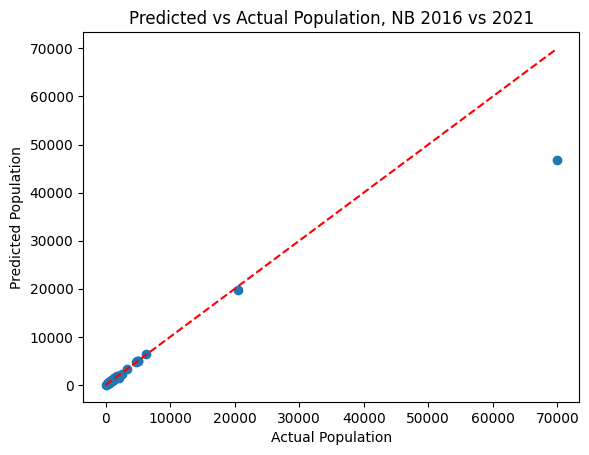

In [18]:
# Let's plot the predicted vs actual values
plt.scatter(yVal, yPred)
# Add a line for perfect correlation
plt.plot([y.min(), y.max()], [y.min(), y.max()],  '--', color='red')
plt.xlabel('Actual Population')
plt.ylabel('Predicted Population')
plt.title(f'Predicted vs Actual Population, {dataSetName} 2016 vs 2021')

# As with the other plots, let's save things to our figures folder
plt.savefig(f'./figures/predicting_vs_actual_census_only_{dataSetName}.png')


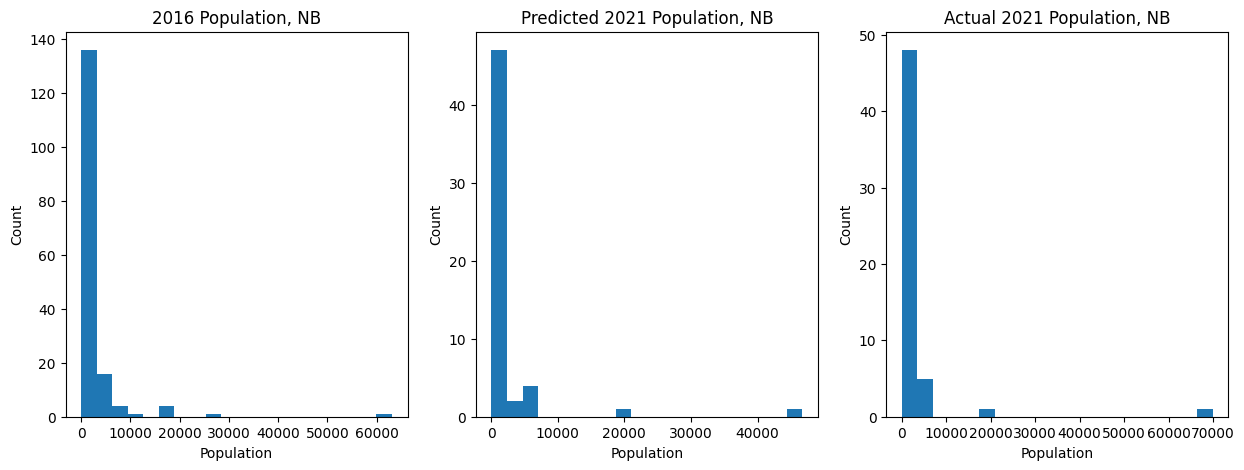

In [19]:
# Let's also plot the 2016 distribution, the predicted distribution, and the actual distribution
# as a set of subplots.
# This will let us see how the communities changed over time
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
dataSets = [yTrain, yPred, yVal]
titles = [f'2016 Population, {dataSetName}', f'Predicted 2021 Population, {dataSetName}', f'Actual 2021 Population, {dataSetName}']
for i in range(3):
    axs[i].hist(dataSets[i], bins=20)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Population')
    axs[i].set_ylabel('Count')

# Let's save the plot in our figures folder
plt.savefig(f'./figures/pred_distributions_census_only_{dataSetName}.png')



Total - Income statistics in 2015 for two-or-more-person private households - 100% data: 0.025671298678095193
Total - Private households by number of persons per room - 25% sample data: 0.025615608654562846
30 to 34 years: 0.02247202384018464
One-census-family households: 0.021697325566080082
Total - Income statistics in 2015 for economic families in private households - 25% sample data: 0.021068704114675114
40 to 44 years: 0.020368768357102534
Population, 2011: 0.019348094232931937
Total - Population by Registered or Treaty Indian status for the population in private households - 25% sample data: 0.017204243734117716
Number of after-tax income recipients aged 15 years and over in private households - 25% sample data: 0.017093093339896056
Total - Citizenship for the population in private households - 25% sample data: 0.016834700349531214


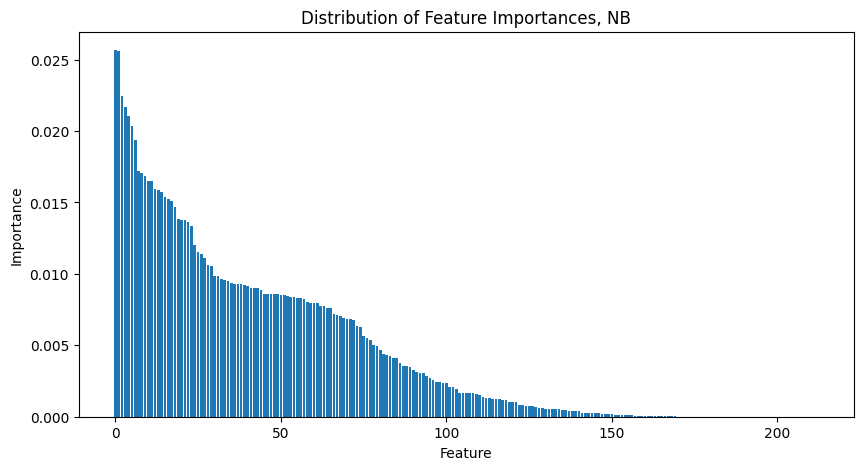

In [22]:
# Plot the feature importances and list the 10 most important features
importances = model.named_steps['regressor'].feature_importances_
featuresUnified = X.columns
indices = np.argsort(importances)[::-1]

# We'll print the top 10 features
for i in range(10):
    print(f'{featuresUnified[indices[i]]}: {importances[indices[i]]}')

# Nothing stands out as any obvious high-importance outliers, but let's plot the importances
plt.figure(figsize=(10, 5))
plt.bar(range(X.shape[1]), importances[indices])
plt.title(f'Distribution of Feature Importances, {dataSetName}')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.savefig(f'./figures/feature_importances_{dataSetName}.png')




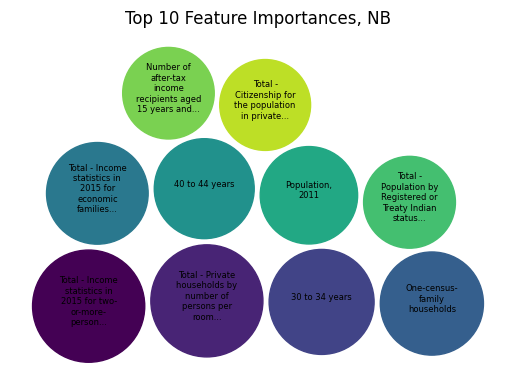

In [143]:
# For a final bit of visualization of the importances, let's use this stacked bubble plot
# algorithm from https://matplotlib.org/stable/gallery/misc/packed_bubbles.html
# It has been modified a little to account for long feature names

# We'll also add the textwrap library to help with formatting the features
import textwrap

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center', fontsize=6)

# We'll plot the top features, using the feature names as labels 
# and the importances as the areas
featureCount = 10
topFeatures = featuresUnified[indices[:featureCount]]
# topFeatures = [ 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
topImportances = importances[indices[:featureCount]]
colors = []

wrapper = textwrap.TextWrapper(width=15)
wrappedFeatures = []
for feature in topFeatures:
    feature = textwrap.shorten(feature, width=60, placeholder='...')
    segments = wrapper.wrap(feature)
    wrappedFeature = ''
    # Join the segments with a newline
    for segment in segments:
        wrappedFeature += segment + '\n'
    wrappedFeatures.append(wrappedFeature)

for i in range(featureCount):
    colors.append(plt.cm.viridis(i / featureCount))

bubbles = BubbleChart(area = topImportances, bubble_spacing=0.01)
bubbles.collapse()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubbles.plot(
    ax, wrappedFeatures, colors )
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title(f'Top 10 Feature Importances, {dataSetName}')

plt.show() 

